In [1]:
import numpy  as np
import healpy as hp
import matplotlib.pyplot as plt
import sys
#
sys.path.append('../sht')
from  mask_deconvolution import MaskDeconvolution
#
%load_ext autoreload
%autoreload 2

# Test the pseudo-spectrum code.

We want to test that the mask convolution and the mode-coupling matrix are being computed correctly.

First we make an apodized mask for our survey.  In our case this will be a Gaussian, centered at $x=1$, $y=z=0$ and set to zero beyond some radius -- but this is essentially arbitrary.

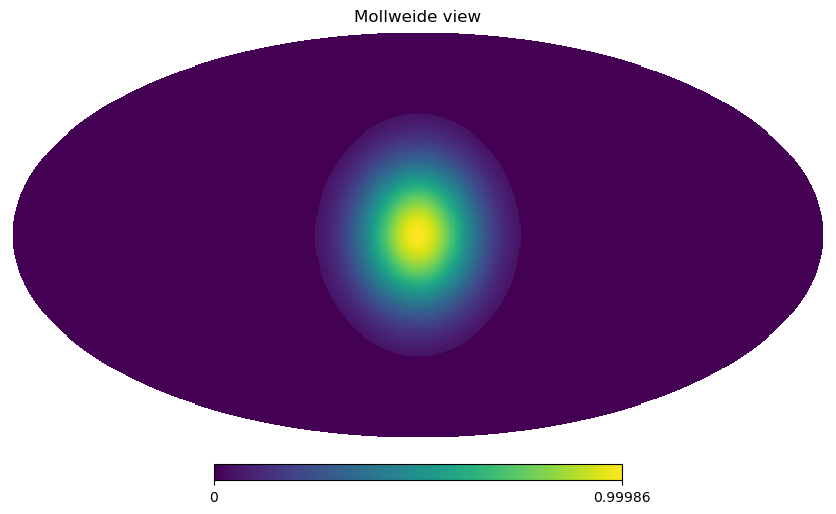

In [2]:
# Generate an apodized mask that is centered on x=1, y=z=0 and
# has an nside of 512.
nside = 512
npix  = 12*nside**2
th,ph = hp.pixelfunc.pix2ang(nside,np.arange(npix),lonlat=False)
#
x,y,z = np.sin(th)*np.cos(ph),np.sin(th)*np.sin(ph),np.cos(th)
rad2  = ( (x-1)**2+y**2+z**2)/0.1
mask  = np.exp(-0.5*rad2)
mask[mask<0.05] = 0.0
# and look at it.
hp.mollview(mask)

Text(0, 0.5, '$W_\\ell$')

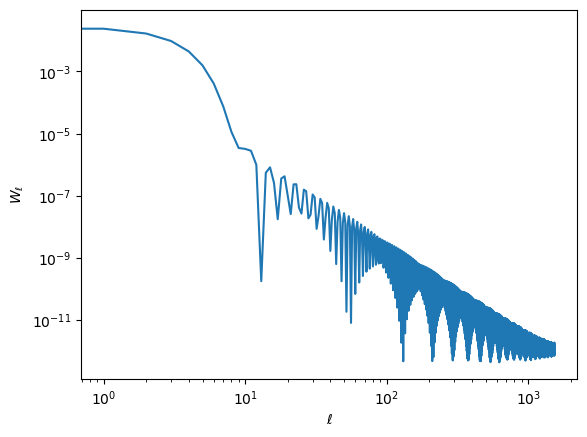

In [3]:
# Let's look at the window function, just to see how
# it looks.
wl = hp.anafast(mask)
#
plt.loglog(wl)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$W_\ell$')

Now we make some mock data using Healpy's synfast routine to generate a Gaussian random field with an input (angular) power spectrum.  We can then mask this map.

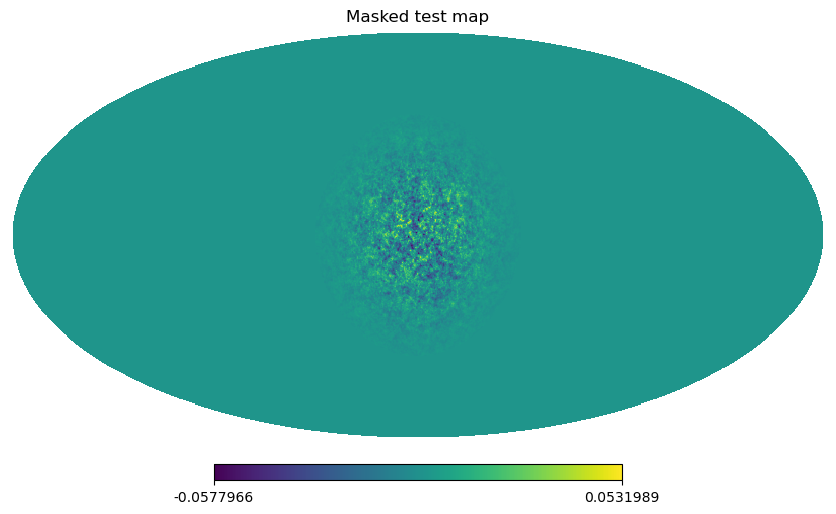

In [4]:
# Make a fiducial angular power spectrum to generate data
# from.  We want this to be very "red" so that we can run
# at reasonably low resolution without worrying about aliasing.
lmax = 3000
ell0 = 32
ell1 = 512
ells = np.arange(lmax)
clkk = 1e-6*ell0/(ells+ell0)*(ell1/(ells+ell1))**6
# Let's draw a realization of this field
kmap = hp.synfast(clkk,nside=nside)
hp.mollview(mask*kmap, title="Masked test map")

Now we analyze this masked data using Healpy's anafast routine.  Note we're going to concentrate on the lower ells here, even though we have a high enough Nside to go to higher ell.

In [5]:
Nl   = 2**8
lmax = Nl-1

In [6]:
# Generate the signal and window function.
cl = hp.anafast(mask*kmap,lmax=lmax)
wl = hp.anafast(mask)

We initialize an instance of the MaskDeconvolution class. This computes the coupling matrix.  This isn't optimized, but we won't have to run it again as long as we're dealing with the same mask so we don't mind.

In [7]:
%time MD = MaskDeconvolution(lmax, wl)

Precomputing Wigner 3j symbols...
Computing the mode-coupling matrix...
CPU times: user 15.5 s, sys: 172 ms, total: 15.6 s
Wall time: 15.5 s


We can then very quickly deconvolve the mode-coupling matrix from some observed bandpowers.

In [8]:
NperBin = 2**4
binned_ells, Cb_decoupled = MD(cl,NperBin)
# Convolve the theory with the bandpower window functions
convolved_theory_cl = MD.convolve_theory_Cls(clkk[:(lmax+1)])

(0.0, 297.5)

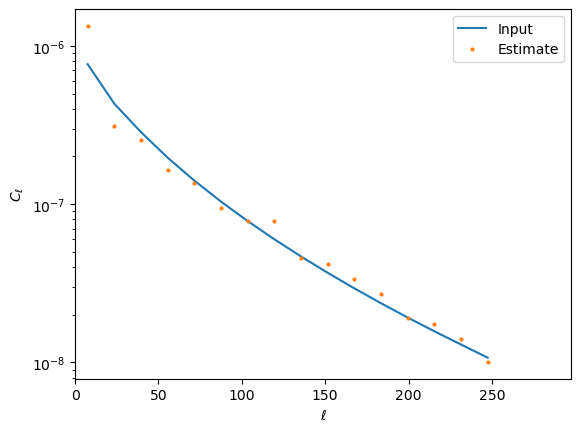

In [9]:
plt.plot(binned_ells, convolved_theory_cl, label='Input')
plt.plot(binned_ells, Cb_decoupled, label='Estimate', ls='', marker='o', markersize=2)
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.legend()
plt.xlim([0,binned_ells[-1]+50])

Let's average over many realizations

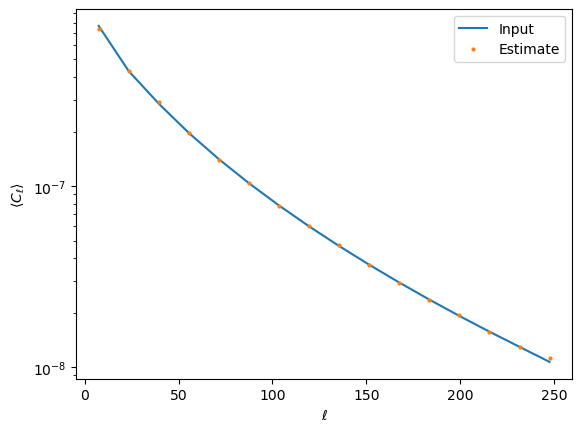

In [10]:
Nmc = 500
#
Cb_array = np.zeros( (Nmc,Cb_decoupled.size) )
#
for i in range(Nmc):
    kmap = hp.synfast(clkk,nside=nside)
    cl   = hp.anafast(mask*kmap,lmax=lmax)
    binned_ells, pseudo_Cb = MD(cl,NperBin)
    Cb_array[i,:] = pseudo_Cb
avg_Cb_decoupled = np.mean(Cb_array,axis=0)
err_Cb_decoupled = np.std( Cb_array,axis=0)/np.sqrt(Nmc-1.0)
#
plt.plot(binned_ells, convolved_theory_cl, label='Input')
plt.plot(binned_ells, avg_Cb_decoupled, label='Estimate', ls='', marker='o', markersize=2)
plt.yscale('log')
plt.legend()
#
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\langle C_\ell \rangle$')
plt.show()

Text(0, 0.5, 'Fractional difference')

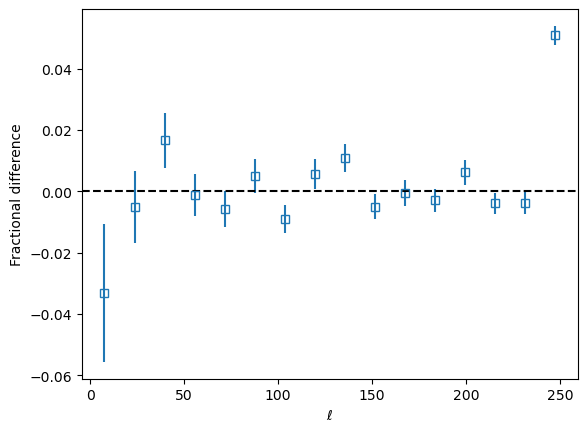

In [11]:
plt.errorbar(binned_ells,avg_Cb_decoupled/convolved_theory_cl-1,\
             yerr=err_Cb_decoupled/convolved_theory_cl,fmt='s',mfc='None')
plt.axhline(0, ls='--', color='k')
plt.xlabel(r'$\ell$')
plt.ylabel(r'Fractional difference')

# The End